In [1]:
from ipynb.fs.full.preprocessing_text import PreprocessTweet
from ipynb.fs.full.dict_lexicons import read_lexicon
from ipynb.fs.full.lexicon_mapping import LexiconMapper, Analyzer
from ipynb.fs.full.bert_helper import create_raw_input, pull_bert, get_max_lengths, bert_encode
import pandas as pd

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [2]:
vad_lexicon = read_lexicon('NRC-VAD')
df = pd.read_csv("D:\\Marko\\MoviesSentimentAnalysis\\140SentimentDataset\\training.1600000.processed.noemoticon.csv", 
           names = [
                    'target',
                    'id',
                    'date',
                    'flag',
                    'user',
                    'text'
                ])
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
xy_df = pd.DataFrame(df.values[:,0:6:5], columns=['label', 'text'])
xy_df.head()

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [4]:
preprocessor = PreprocessTweet()
preprocessed_df = preprocessor.preprocess_tweets(xy_df, False, True)
preprocessed_df.head()

,Label,Tweet,Mark,Caps,Letters
0,0,awww thats a bummer you shoulda got david carr...,False,False,True
1,0,is upset that he cant update his facebook by t...,True,False,True
2,0,i dived many times for the ball managed to sav...,False,True,False
3,0,my whole body feels itchy and like its on fire,False,False,False
4,0,no its not behaving at all im mad why am i her...,False,True,False


In [5]:
preprocessed_stopwords = preprocessor.preprocess_tweets(xy_df, False, False)
df_stopwords = preprocessor.remove_stopwords(\
                                             pd.DataFrame(preprocessed_stopwords.values, \
                                             columns = ['label', 'text', 'mark', 'caps', 'letters']))
df_stopwords.head()

,label,text,mark,caps,letters,stopwordsx
0,0,awww that s a bummer you shoulda got david car...,False,False,True,awww bummer shoulda got david carr third day
1,0,is upset that he can t update his facebook by ...,True,False,True,upset update facebook texting might cry result...
2,0,i dived many times for the ball managed to sav...,False,True,False,dived many times ball managed save rest go bounds
3,0,my whole body feels itchy and like its on fire,False,False,False,whole body feels itchy like fire
4,0,no it s not behaving at all i m mad why am i h...,False,True,False,behaving mad see


In [6]:
mapper = LexiconMapper()
mapped_tweets = mapper.map_tweets(pd.DataFrame(df_stopwords.values[:,5], columns=['text']), vad_lexicon, 2, True)
mapped_tweets['original'] = preprocessed_df.values[:,1]
mapped_tweets['mark'] = preprocessed_df.values[:,2]
mapped_tweets['caps'] = preprocessed_df.values[:,3]
mapped_tweets['letters'] = preprocessed_df.values[:,4]

In [7]:
mapped_tweets.head()

,text,mapped,original,mark,caps,letters
0,awww bummer shoulda got david carr third day,"[-1, 0.267, -1, -1, -1, 0.5, 0.304, 0.389]",awww thats a bummer you shoulda got david carr...,False,False,True
1,upset update facebook texting might cry result...,"[0.33, 0.802, -1, -1, -1, 0.255, 0.652, 0.633,...",is upset that he cant update his facebook by t...,True,False,True
2,dived many times ball managed save rest go bounds,"[-1, -1, 0.439, 0.317, -1, 0.682, 0.3, 0.444, ...",i dived many times for the ball managed to sav...,False,True,False
3,whole body feels itchy like fire,"[0.572, 0.571, -1, 0.296, 0.446, 0.635]",my whole body feels itchy and like its on fire,False,False,False
4,behaving mad see,"[-1, 0.277, 0.312]",no its not behaving at all im mad why am i her...,False,True,False


In [8]:
filtered_nulls = pd.DataFrame([i for i in mapped_tweets.values if len(i[1]) > 0], columns=['text','mapped', 'original', 'mark', 'caps', 'letters'])
print(len(filtered_nulls))
print(len(mapped_tweets))
filtered_nulls = mapper.filter_tweets(filtered_nulls, -1, 0.35)
filtered_nulls.head()
import copy
filtered = copy.deepcopy(filtered_nulls[filtered_nulls.filtered == True])
maximums = mapper.get_maximum(filtered.mapped)
averages = mapper.get_average(filtered.mapped)

1590017
1600000


In [9]:
print(maximums[:10])
print(averages[:10])
filtered['maximums'] = maximums
filtered['averages'] = averages
filtered.head()

[0.682, 0.635, 0.312, 0.735, 0.548, 0.508, 0.571, 0.647, 0.7, 0.629]
[0.46, 0.5, 0.29, 0.65, 0.37, 0.41, 0.38, 0.51, 0.49, 0.37]


,text,mapped,original,mark,caps,letters,filtered,maximums,averages
2,dived many times ball managed save rest go bounds,"[-1, -1, 0.439, 0.317, -1, 0.682, 0.3, 0.444, ...",i dived many times for the ball managed to sav...,False,True,False,True,0.682,0.46
3,whole body feels itchy like fire,"[0.572, 0.571, -1, 0.296, 0.446, 0.635]",my whole body feels itchy and like its on fire,False,False,False,True,0.635,0.50
4,behaving mad see,"[-1, 0.277, 0.312]",no its not behaving at all im mad why am i her...,False,True,False,True,0.312,0.29
5,whole crew,"[0.572, 0.735]",not the whole crew,False,False,False,True,0.735,0.65
6,need hug,"[0.2, 0.548]",need a hug,False,False,False,True,0.548,0.37


In [15]:
from collections import Counter
variances = []
for i in filtered.values:
    if len(i[1]) < 3:
        variances.append(0)
        continue
    variance = 0
    elms = 0
    for j in i[1]:
        if j != -1:
            variance = variance + (abs((j - i[8])) * abs((j - i[8])))
            elms = elms + 1
    variances.append(round(variance/(elms-1),2))
print(Counter(variances))
filtered['variance'] = variances
filtered.head()

Counter({0.02: 147245, 0.0: 140374, 0.01: 128336, 0.03: 119783, 0.04: 74333, 0.05: 40933, 0.06: 21532, 0.07: 11427, 0.08: 6620, 0.09: 3882, 0.1: 2377, 0.11: 1511, 0.12: 1077, 0.13: 712, 0.14: 425, 0.15: 397, 0.16: 244, 0.17: 147, 0.19: 114, 0.18: 109, 0.2: 98, 0.21: 48, 0.24: 36, 0.23: 34, 0.22: 33, 0.27: 14, 0.25: 14, 0.26: 9, 0.29: 5, 0.28: 4, 0.3: 4, 0.32: 3, 0.35: 1})


,text,mapped,original,mark,caps,letters,filtered,maximums,averages,avg_labels,max_labels,variance
2,dived many times ball managed save rest go bounds,"[-1, -1, 0.439, 0.317, -1, 0.682, 0.3, 0.444, ...",i dived many times for the ball managed to sav...,False,True,False,True,0.682,0.46,medium,medium,0.02
3,whole body feels itchy like fire,"[0.572, 0.571, -1, 0.296, 0.446, 0.635]",my whole body feels itchy and like its on fire,False,False,False,True,0.635,0.50,medium,medium,0.02
4,behaving mad see,"[-1, 0.277, 0.312]",no its not behaving at all im mad why am i her...,False,True,False,True,0.312,0.29,low,low,0.00
5,whole crew,"[0.572, 0.735]",not the whole crew,False,False,False,True,0.735,0.65,medium,medium,0.00
6,need hug,"[0.2, 0.548]",need a hug,False,False,False,True,0.548,0.37,medium,medium,0.00


In [17]:
analyzer = Analyzer()
analyze_avg = analyzer.labels_distribution(averages, 0.33, 0.66)
analyze_max = analyzer.labels_distribution(maximums, 0.5, 0.85)

print(analyze_max)
print(analyze_avg)

min_sample_max = min(analyze_max)
min_sample_avg = min(analyze_avg)

(79243, 650607, 51274)
(27836, 669953, 31928)


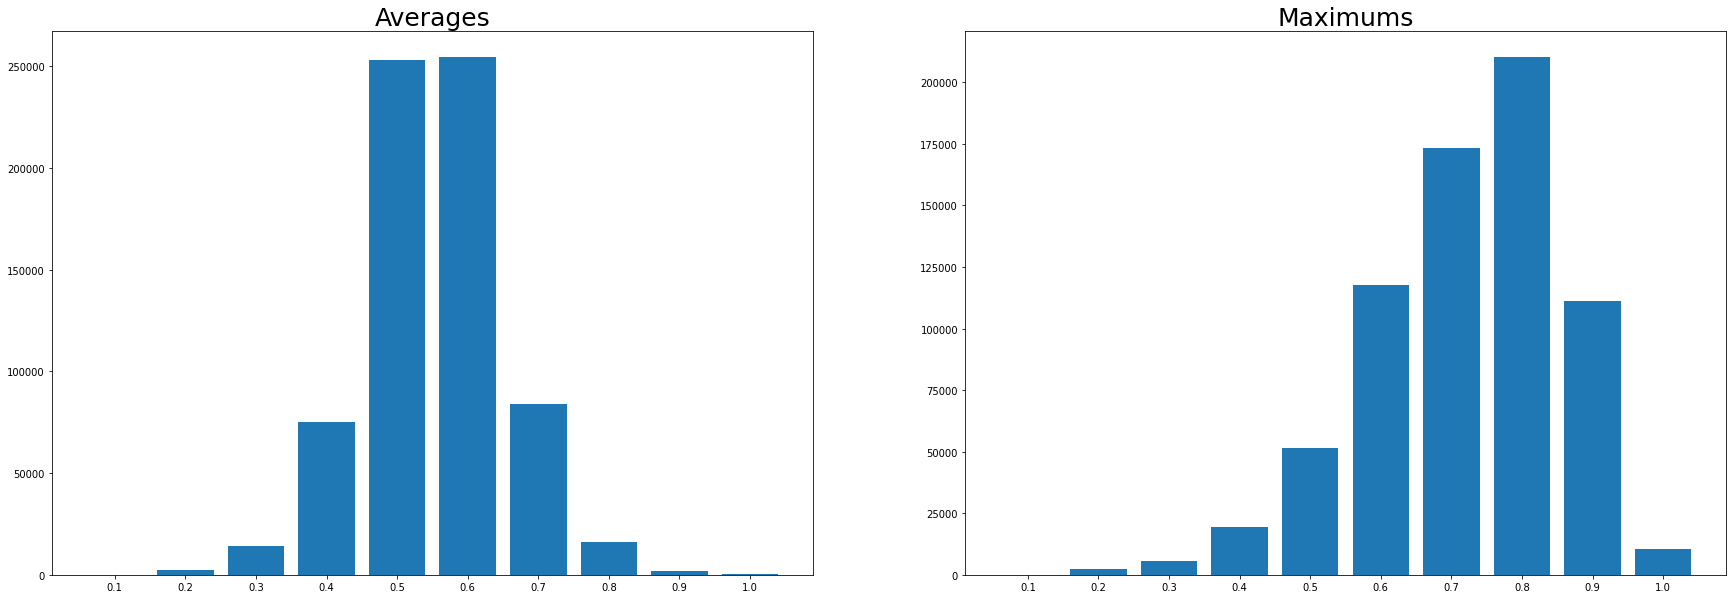

In [18]:
from collections import Counter
import matplotlib.pyplot as plt

def visualize(aggregate):
    d_a = {"0.1": 0, "0.2": 0, "0.3": 0, "0.4": 0, "0.5":0, "0.6": 0, "0.7": 0, "0.8": 0, "0.9": 0, "1.0":0}
    for j in aggregate:
        if j > 0 and j < 0.1:
            d_a["0.1"] = d_a["0.1"] + 1
        if j >= 0.1 and j < 0.2:
            d_a["0.2"] = d_a["0.2"] + 1
        elif j >= 0.2 and j < 0.3:
            d_a["0.3"] = d_a["0.3"] + 1
        elif j >= 0.3 and j < 0.4:
            d_a["0.4"] = d_a["0.4"] + 1
        elif j >= 0.4 and j < 0.5:
            d_a["0.5"] = d_a["0.5"] + 1
        elif j >= 0.5 and j < 0.6:
            d_a["0.6"] = d_a["0.6"] + 1
        elif j >= 0.6 and j < 0.7:
            d_a["0.7"] = d_a["0.7"] + 1
        elif j >= 0.7 and j < 0.8:
            d_a["0.8"] = d_a["0.8"] + 1
        elif j >= 0.8 and j < 0.9:
            d_a["0.9"] = d_a["0.9"] + 1
        else:
            d_a["1.0"] = d_a["1.0"] + 1
    return d_a
data = [visualize(averages), visualize(maximums)]
titles = ['Averages', 'Maximums']
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(30,10))
for i, ax, title in zip(data, axes, titles):
    ax.set_title(title, size=25)
    ax.bar([k for k in i.keys()], i.values())
plt.show()

In [19]:
lens = analyzer.get_length_statistics(filtered)

<BarContainer object of 27 artists>

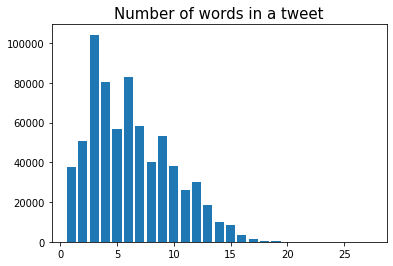

In [20]:
import matplotlib.pyplot as plt

plt.title("Number of words in a tweet", size=15)
plt.bar([k for k in lens.keys()], lens.values())

In [28]:
def add_labels(tweets, index, low_bound, mlower_bound, mupper_bound, high_bound):
    classes = []
    for i in tweets.values[:,index]:
        if i >= high_bound:
            classes.append("high")
        elif i <= low_bound and i > 0:
            classes.append("low")
        elif i > mlower_bound and i < mupper_bound:
            classes.append("medium")
        else:
            classes.append("none")
        
    tweets['values'] = classes
        
    return tweets

filtered = add_labels(filtered, 8, 0.3, 0.4, 0.55, 0.7)
filtered.head()
filtered.columns=['text', 'mapped', 'original', 'mark', 'caps', 'letters', 'filtered', 'maximums', 'averages', 'variance', 'avg_labels']
filtered = add_labels(filtered, 7, 0.4, 0.55, 0.65, 0.8)
filtered.columns=['text', 'mapped', 'original', 'mark', 'caps', 'letters', 'filtered', 'maximums', 'averages', 'variance', 'avg_labels', 'max_labels']
filtered.head()
#filtered = filtered.drop(['avg_labels', 'max_labels'], axis = 1)

,text,mapped,original,mark,caps,letters,filtered,maximums,averages,variance,avg_labels,max_labels
2,dived many times ball managed save rest go bounds,"[-1, -1, 0.439, 0.317, -1, 0.682, 0.3, 0.444, ...",i dived many times for the ball managed to sav...,False,True,False,True,0.682,0.46,0.02,medium,none
3,whole body feels itchy like fire,"[0.572, 0.571, -1, 0.296, 0.446, 0.635]",my whole body feels itchy and like its on fire,False,False,False,True,0.635,0.50,0.02,medium,medium
4,behaving mad see,"[-1, 0.277, 0.312]",no its not behaving at all im mad why am i her...,False,True,False,True,0.312,0.29,0.00,low,low
5,whole crew,"[0.572, 0.735]",not the whole crew,False,False,False,True,0.735,0.65,0.00,none,none
6,need hug,"[0.2, 0.548]",need a hug,False,False,False,True,0.548,0.37,0.00,none,none


<ipython-input-29-91416567776d>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_filtered = filtered[filtered.variance < 0.07][filtered.variance > 0]


7190


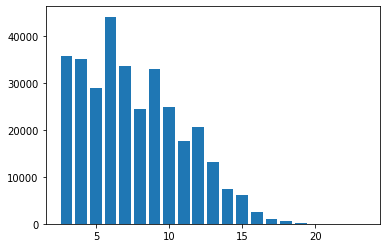

In [29]:
new_filtered = filtered[filtered.variance < 0.07][filtered.variance > 0]
new_filtered = new_filtered[new_filtered.avg_labels != 'none']
new_filtered.head()
print(len(new_filtered[new_filtered.avg_labels == "high"]))
filtered_new_lens = analyzer.get_length_statistics(new_filtered)

plt.bar([k for k in filtered_new_lens.keys()], filtered_new_lens.values())
plt.show()

In [48]:
def get_even_distribution(df, attr, min_sample_size):
    
    df_low = df[df[attr] == 'low'][df.maximums < 0.5]
    df_med = df[df[attr] == 'medium'][df.maximums < 0.65]
    low_df = mapper.get_sample(df_low, df_low[attr], "low", min_sample_size)
    med_df = mapper.get_sample(df_med, df_med[attr], "medium", min_sample_size)
    high_df = mapper.get_sample(df, df[attr], "high", min_sample_size)
    
    distr_df = pd.concat([low_df, med_df, high_df])
    return distr_df

avg_df = get_even_distribution(new_filtered, 'avg_labels', 6500)
max_df = get_even_distribution(new_filtered, 'max_labels', 3000)
print(max_df.shape)
print(avg_df.shape)
max_df.head()

<ipython-input-48-231dc4d72e33>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_low = df[df[attr] == 'low'][df.maximums < 0.5]
<ipython-input-48-231dc4d72e33>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_med = df[df[attr] == 'medium'][df.maximums < 0.65]
<ipython-input-48-231dc4d72e33>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_low = df[df[attr] == 'low'][df.maximums < 0.5]
<ipython-input-48-231dc4d72e33>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_med = df[df[attr] == 'medium'][df.maximums < 0.65]


(9000, 12)
(19500, 12)


,text,mapped,original,mark,caps,letters,filtered,maximums,averages,variance,avg_labels,max_labels
598548,another slow day,"[-1, 0.131, 0.389]",another slow day,False,False,False,True,0.389,0.26,0.03,low,low
451705,tummy hurts bad,"[0.23, -1, 0.373]",my tummy hurts so bad,False,False,False,True,0.373,0.30,0.01,low,low
669056,poor michelle orange legs,"[0.087, -1, 0.296, 0.228]",poor michelles orange legs,False,False,False,True,0.296,0.20,0.01,low,low
394925,ear hurts still stupid fucking cold,"[0.231, -1, -1, 0.2, 0.39, 0.348]",my ear hurts i still have this stupid fucking ...,False,True,False,True,0.390,0.29,0.01,low,low
503136,seriously need sleep,"[-1, 0.2, 0.339]",seriously i need sleep,False,False,False,True,0.339,0.27,0.01,low,low


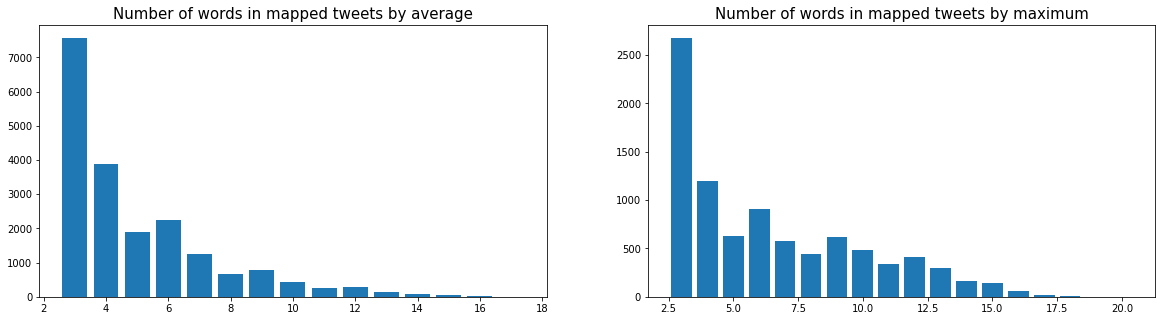

In [49]:
avg_lens = analyzer.get_length_statistics(avg_df)
max_lens = analyzer.get_length_statistics(max_df)

data = [avg_lens, max_lens]
titles = ["Number of words in mapped tweets by average", "Number of words in mapped tweets by maximum", ]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
for rec, ax, title in zip(data, axes, titles):
    ax.set_title(title, size=15)
    ax.bar([k for k in rec.keys()], rec.values())

In [50]:
def init_transfered_model(df, attr):
    x_train, x_test, y_train, y_test = create_raw_input(df['original'], df[attr], 0.2)
    bert_layer, tokenizer = pull_bert('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/2')
    #max_seq_len = get_max_lengths(df['original'], tokenizer)
    
    X_train = bert_encode(x_train, tokenizer, 150)
    X_test = bert_encode(x_test, tokenizer, 150)
    
    return X_train, X_test, y_train, y_test, bert_layer

avgX_train, avgX_test, avgy_train, avgy_test, avgbert_layer = init_transfered_model(avg_df, 'avg_labels')
maxX_train, maxX_test, maxy_train, maxy_test, maxbert_layer = init_transfered_model(max_df, 'max_labels')

In [51]:
import tensorflow as tf

def create_model(bert_layer, max_seq_len, num_class):

    input_word_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_type_ids")

    bert_input = {
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    }

    outputs = bert_layer(bert_input)
    #print(outputs)
    pooled_output = outputs['pooled_output']
    sequence_output = outputs['sequence_output']

    print(pooled_output)

    output = tf.keras.layers.Dropout(rate=0.1)(sequence_output)
    output = tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu')(output)
    output = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu')(output)
    output = tf.keras.layers.AvgPool1D(pool_size=2)(output)
    output = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(output)
    output = tf.keras.layers.AvgPool1D(pool_size=2)(output)
    output = tf.keras.layers.Conv1D(filters=8, kernel_size=3, activation='relu')(output)
    output = tf.keras.layers.Flatten()(output)
    output = tf.keras.layers.Dense(num_class, activation='softmax')(output)

    model = tf.keras.Model(
        inputs={
            'input_word_ids': input_word_ids,
            'input_mask': input_mask,
            'input_type_ids': input_type_ids
        },
        outputs=output
    )

    model.summary()

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics='accuracy'
    )
    
    return model

model_avg = create_model(avgbert_layer, 150, len(avgy_train[0]))
#model_max = create_model(maxbert_layer, maxmax_seq_len, len(maxy_train[0]))

KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='keras_layer_2/StatefulPartitionedCall:5', description="created by layer 'keras_layer_2'")
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
keras_layer_2

In [52]:
history_avg = model_avg.fit(
    avgX_train,
    avgy_train,
    epochs=4,
    verbose=1
)

Epoch 1/4
488/488 [==============================] - 573s 1s/step - loss: 0.4969 - accuracy: 0.7944
Epoch 2/4
488/488 [==============================] - 548s 1s/step - loss: 0.3656 - accuracy: 0.8549
Epoch 3/4
488/488 [==============================] - 547s 1s/step - loss: 0.3111 - accuracy: 0.8779
Epoch 4/4
488/488 [==============================] - 538s 1s/step - loss: 0.2555 - accuracy: 0.8980


In [53]:
model_avg.save('D:/model_dom_new/avg_model')

INFO:tensorflow:Assets written to: D:/model_dom_new/avg_model\assets


INFO:tensorflow:Assets written to: D:/model_dom_new/avg_model\assets


In [24]:
model_max = create_model(maxbert_layer, 150, len(maxy_train[0]))
history_max = model_max.fit(
    maxX_train,
    maxy_train,
    epochs=4,
    verbose=1
)

KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='keras_layer_3/StatefulPartitionedCall:3', description="created by layer 'keras_layer_3'")
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
keras_layer_3

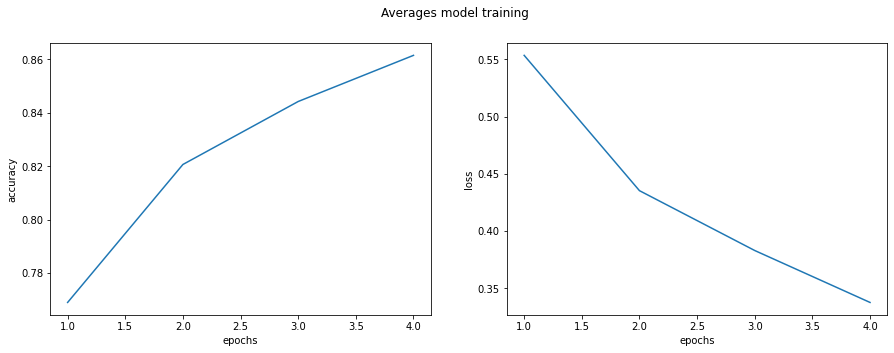

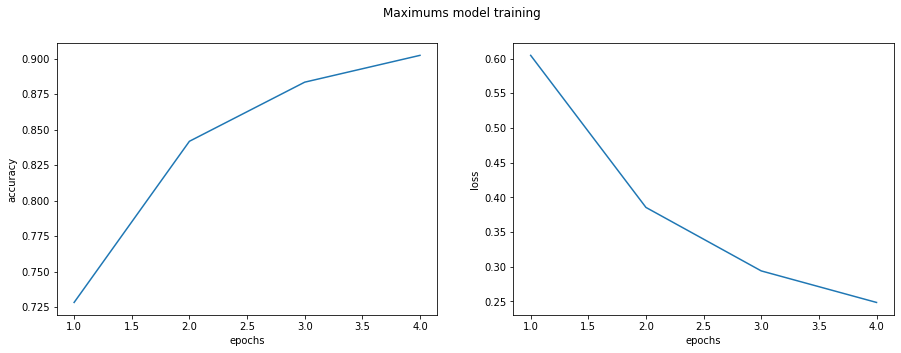

In [25]:
import matplotlib.pyplot as plt

def show_results(history, subtitle):
    metrics_data = [history.history['accuracy'], history.history['loss']]
    labels = ['accuracy', 'loss']
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    fig.suptitle(subtitle)

    for data, ax, label in zip(metrics_data, axes, labels):
        ax.set_xlabel('epochs')
        ax.set_ylabel(label)
        ax.plot(range(1,5), data)

    plt.show()
    
show_results(history_avg, "Averages model training")
show_results(history_max, "Maximums model training")

In [26]:
model_avg.save('D:/dominance_models_75/avg_model')

INFO:tensorflow:Assets written to: D:/dominance_models_75/avg_model\assets


INFO:tensorflow:Assets written to: D:/dominance_models_75/avg_model\assets


In [27]:
model_max.save('D:/dominance_models_75/max_model')

INFO:tensorflow:Assets written to: D:/dominance_models_75/max_model\assets


INFO:tensorflow:Assets written to: D:/dominance_models_75/max_model\assets


In [28]:
model_avg.evaluate(avgX_test, avgy_test)

320/320 [==============================] - 185s 572ms/step - loss: 0.3542 - accuracy: 0.8567


[0.35417723655700684, 0.8566963076591492]

In [29]:
model_max.evaluate(maxX_test, maxy_test)

709/709 [==============================] - 380s 536ms/step - loss: 0.2486 - accuracy: 0.9054


[0.24862359464168549, 0.9054006338119507]